In [1]:
from dotenv import load_dotenv

from IPython.display import Image, display
import gradio as gr

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_ollama import ChatOllama

from typing import Annotated, TypedDict
import getpass4
import os

/home/luecha-kanm/Documents/Dev/Agintic-AI/agentic_ai_engineer_course/4_langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass4.getpass("Enter your Google AI API key: ")

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.checkpoint.memory import MemorySaver

serper = GoogleSerperAPIWrapper()
# serper.run("What is the capital of France?")

memory = MemorySaver()

In [4]:
from langchain.agents import Tool

tool_search = Tool(
    name="search",
    description="Useful for when you need more information from an online search",
    func=serper.run,
)

In [5]:
# tool_search.invoke("What is the capital of France?")

In [6]:
from typing import Any


def calculate_math(expression: str) -> str:
    """Calculate mathematical expressions safely"""
    try:
        # Remove any potentially dangerous characters and evaluate safely
        allowed_chars: set[str] = set("0123456789+-*/(). ")
        if all(c in allowed_chars for c in expression):
            result = eval(expression)
            return f"ผลลัพธ์: {expression} = {result}"
        else:
            return "ข้อผิดพลาด: นิพจน์ไม่ถูกต้อง ใช้ได้เฉพาะตัวเลขและเครื่องหมาย +, -, *, /, (, ) เท่านั้น"
    except Exception as e:
        return f"ข้อผิดพลาดในการคำนวณ: {str(e)}"


calculate_tool: Any = Tool(
    name="calculator",
    func=calculate_math,
    description="Use this to calculate mathematical expressions. Input should be a valid math expression like '2 + 3 * 4' or '(10 + 5) / 3'",
)

calculate_tool.invoke("1+2")

'ผลลัพธ์: 1+2 = 3'

#### Create Tools


In [7]:
tools = [calculate_tool, tool_search]

#### Step 1: Define the State object


In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

#### Step 2: Start the Graph Builder with this State class


In [9]:
graph_builder = StateGraph(State)

In [10]:
llm = ChatOllama(model="gpt-oss")

llm_with_tools = llm.bind_tools(tools)

#### Step 3: Create a Node


In [11]:
def chatbot(state: State) -> State:
    """This function is called when the user sends a message to the chatbot."""

    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

### Step 4: Create Edges


In [12]:
graph_builder.add_conditional_edges("chatbot", tools_condition, {"tools": "tools"})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

### Step 5: Compli the Graph


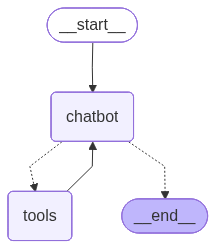

In [13]:
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

#### This's is? And, let's do this.


In [14]:
config = {"configurable": {"thread_id": "123"}}

def chat(user_input: str, history) -> str:
    """This function is called when the user sends a message to the chatbot."""
    result = graph.invoke(
        {"messages": [{"role": "user", "content": user_input}]}, config=config
    )
    print(result)
    
    return result["messages"][-1].content



gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.


In [15]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '123'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [16]:
list(graph.get_state_history(config))

[]

## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.  
**Why isn't this handling memory?**

---

## This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes.  
> Nodes that run in parallel are part of the same super-step,  
> while nodes that run sequentially belong to separate super-steps.

- One **"Super-Step"** of the graph represents one invocation of passing messages between agents.
- In idiomatic LangGraph, you call `invoke()` to run your graph for each super-step; for each interaction.
- The reducer handles state updates automatically **within one super-step**, but **not between them**.

That is what **checkpointing** achieves.


In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory: MemorySaver = MemorySaver()

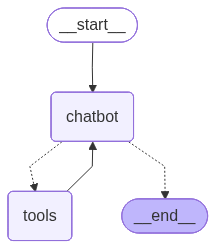

In [18]:
graph_builder = StateGraph(State)

llm = ChatOllama(model="llama3.1")

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State) -> State:
    """This function is called when the user sends a message to the chatbot."""

    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges("chatbot", tools_condition, {"tools": "tools"})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
config = {"configurable": {"thread_id": "222"}}

def chat(user_input: str, history) -> str:
    """This function is called when the user sends a message to the chatbot."""
    result = graph.invoke(
        {"messages": [{"role": "user", "content": user_input}]}, config=config
    )
    print(result)
    
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7877
* To create a public link, set `share=True` in `launch()`.


### LangChain gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

And now let's store in SQL

And this is the power of LangGraph.


In [23]:
import sqlite3
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.sqlite import SqliteSaver


db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

In [ ]:
# Steps 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
# graph_builder.add_conditional_edges("chatbot", tools_condition, {"tools": "tools"})
graph_builder.add_conditional_edges(
    "chatbot", tools_condition, {"tools": "tools", "__end__": END}
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# graph_builder.add_conditional_edges("chatbot", tools_condition, {"tools": "tools"})
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

In [25]:
config = {"configurable": {"thread_id": "3333"}}


def chat(user_input: str, history) -> str:
    """This function is called when the user sends a message to the chatbot."""
    result = graph.invoke(
        {"messages": [{"role": "user", "content": user_input}]}, config=config
    )
    print(result)
    
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7879
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='43ea930d-b60d-4eaf-930b-bb508b25367d'), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='aafddae8-7326-4f3e-8fd7-f39a3e81591f'), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='0f1d1589-02f7-4a71-a57f-e7c88b45dd12'), AIMessage(content='<think>\nOkay, the user just said "hi" again. Let me check the history. The previous message was also "hi". Maybe they\'re testing if I\'m responsive or want to start a conversation. Since there\'s no specific question or request, I should greet them back and offer assistance. Let me keep it friendly and open-ended. Something like, "Hello! How can I assist you today?" That should encourage them to ask something more concrete.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-09-06T10:58:45.410320203Z', 'done': True, 'done_reason': 'stop'

Traceback (most recent call last):
  File "/home/luecha-kanm/Documents/Dev/Agintic-AI/agentic_ai_engineer_course/4_langgraph/.venv/lib/python3.12/site-packages/gradio/queueing.py", line 667, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/luecha-kanm/Documents/Dev/Agintic-AI/agentic_ai_engineer_course/4_langgraph/.venv/lib/python3.12/site-packages/gradio/route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/luecha-kanm/Documents/Dev/Agintic-AI/agentic_ai_engineer_course/4_langgraph/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/luecha-kanm/Documents/Dev/Agintic-AI/agentic_ai_engineer_course/4_langgraph/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 1779, in call_f